# 05a2 – Enhanced 3-Step Floating Catchment Area (E3SFCA) Scenario Modelling

## Overview

This notebook implements the **Enhanced 3-Step Floating Catchment Area (E3SFCA)** model to estimate spatial accessibility to CT scanner services across LSOAs in England. The E3SFCA method builds on the traditional 2SFCA by incorporating:

- Decay functions based on **realistic travel time bands** (car mode),
- **Weighted supply-to-demand ratios** per CT site (Rⱼ),
- **Aggregated accessibility scores (Fᵢ)** for each LSOA, reflecting cumulative opportunity adjusted for catchment overlap and travel friction.

This model serves as the **baseline scenario** for accessibility modelling prior to adding new sites or testing alternative service distributions.

---

## Key Objectives

- Apply a **stepwise decay function** to account for declining willingness to travel with increasing time.
- Compute supply-to-demand ratios (**Rⱼ**) at each CT facility using weighted demand from surrounding LSOAs.
- Generate accessibility scores (**Fᵢ**) per LSOA as the sum of all weighted contributions from accessible facilities.
- Export all outputs for downstream comparison and mapping (e.g., accessibility delta plots, prioritisation maps).

---

## Input Datasets

- LSOA-level demand estimates and geometry (`gdf_lsoa`)
- CT scanner site locations and capacity (`df_sites_ct`)
- Travel time matrix between all LSOAs and CT sites by car (`df_travel_car`)

---

## Outputs

The following datasets are exported to `/data/processed/E3SFCA/`:

- LSOA accessibility scores (GeoPackage + CSV)
- Travel matrix with decay weights
- CT site supply-to-demand ratio table (Rⱼ values)
- CT site capability table with scanner counts

---

## Planning Utility

The E3SFCA score (Fᵢ) can be used to:

- Identify LSOAs with **low spatial access** to CT scanning services,
- Support **site placement strategies** by revealing coverage deserts,
- Quantify the impact of **proposed infrastructure** on accessibility equity.

This model underpins scenario testing in subsequent notebooks (`05a3`, `06a`, etc.).


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import os

# Optional
import warnings
warnings.filterwarnings("ignore")


In [25]:
# ----------------------------------------------------------
# Step 1 – Load Baseline E3SFCA Files (Car Mode + Site Types)
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# E3SFCA input files
lsoa_access_path = os.path.join(processed_dir, "E3SFCA", "lsoa_e3sfca_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(processed_dir, "E3SFCA", "lsoa_to_ct_travel_matrix_car.csv")
ct_sites_path = os.path.join(processed_dir, "E3SFCA", "ct_sites_capability.csv")
rj_path = os.path.join(processed_dir, "E3SFCA", "ct_site_rj_scores_car.csv")

# Load baseline outputs
gdf_lsoa = gpd.read_file(lsoa_access_path)
df_travel_car = pd.read_csv(travel_matrix_path)
df_sites_ct = pd.read_csv(ct_sites_path)
df_rj_car = pd.read_csv(rj_path)

# Raw site capability input (for acute and CDC identification)
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")

df_sites_acute = pd.read_csv(acute_path)
df_sites_cdc = pd.read_csv(cdc_path)

travel_matrix_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw/LSOA_to_LSOA_complete.csv"


# Confirm shapes
print(f"LSOA GeoDataFrame: {gdf_lsoa.shape}")
print(f"Travel Matrix (car ≤60 min): {df_travel_car.shape}")
print(f"CT Sites: {df_sites_ct.shape}")
print(f"Acute Sites: {df_sites_acute.shape}")
print(f"CDC Sites: {df_sites_cdc.shape}")


LSOA GeoDataFrame: (3451, 10)
Travel Matrix (car ≤60 min): (2115893, 16)
CT Sites: (36, 23)
Acute Sites: (18, 23)
CDC Sites: (24, 22)


In [5]:
# ----------------------------------------------------------
# Step 1a – Filter Acute and CDC Sites with >0 CT Scanners
# ----------------------------------------------------------

# Clean CT scanner columns (ensure numeric and fill NaNs as 0)
df_sites_acute["CT Scanners"] = pd.to_numeric(df_sites_acute["CT Scanners"], errors="coerce").fillna(0)
df_sites_cdc["CT Scanners"] = pd.to_numeric(df_sites_cdc["CT Scanners"], errors="coerce").fillna(0)

# Filter for sites with 1 or more scanners
df_acute_ct = df_sites_acute[df_sites_acute["CT Scanners"] > 0].copy()
df_cdc_ct = df_sites_cdc[df_sites_cdc["CT Scanners"] > 0].copy()

# Summary counts
print(f"Acute sites with ≥1 CT scanner: {df_acute_ct.shape[0]}")
print(f"CDC sites with ≥1 CT scanner: {df_cdc_ct.shape[0]}")


Acute sites with ≥1 CT scanner: 18
CDC sites with ≥1 CT scanner: 18


In [7]:
# ----------------------------------------------------------
# Step 2 – Identify Priority Underserved LSOAs (High Demand + Low Access)
# ----------------------------------------------------------

# 1. Define thresholds for "low access" (bottom 33%) and "high demand" (above median)
score_threshold = gdf_lsoa["enhanced_3sfca_score"].quantile(0.33)   # bottom 33%
demand_threshold = gdf_lsoa["ct_total_demand"].median()             # above-median demand

# 2. Apply filters
gdf_lsoa["low_access"] = gdf_lsoa["enhanced_3sfca_score"] <= score_threshold
gdf_lsoa["high_demand"] = gdf_lsoa["ct_total_demand"] >= demand_threshold

# 3. Tag LSOAs that meet both criteria
gdf_lsoa["priority_underserved"] = gdf_lsoa["low_access"] & gdf_lsoa["high_demand"]

# 4. Create filtered GeoDataFrame
gdf_priority = gdf_lsoa[gdf_lsoa["priority_underserved"]].copy()

# 5. Output check
print(f"Priority underserved LSOAs identified: {gdf_priority.shape[0]} of {gdf_lsoa.shape[0]}")


Priority underserved LSOAs identified: 713 of 3451


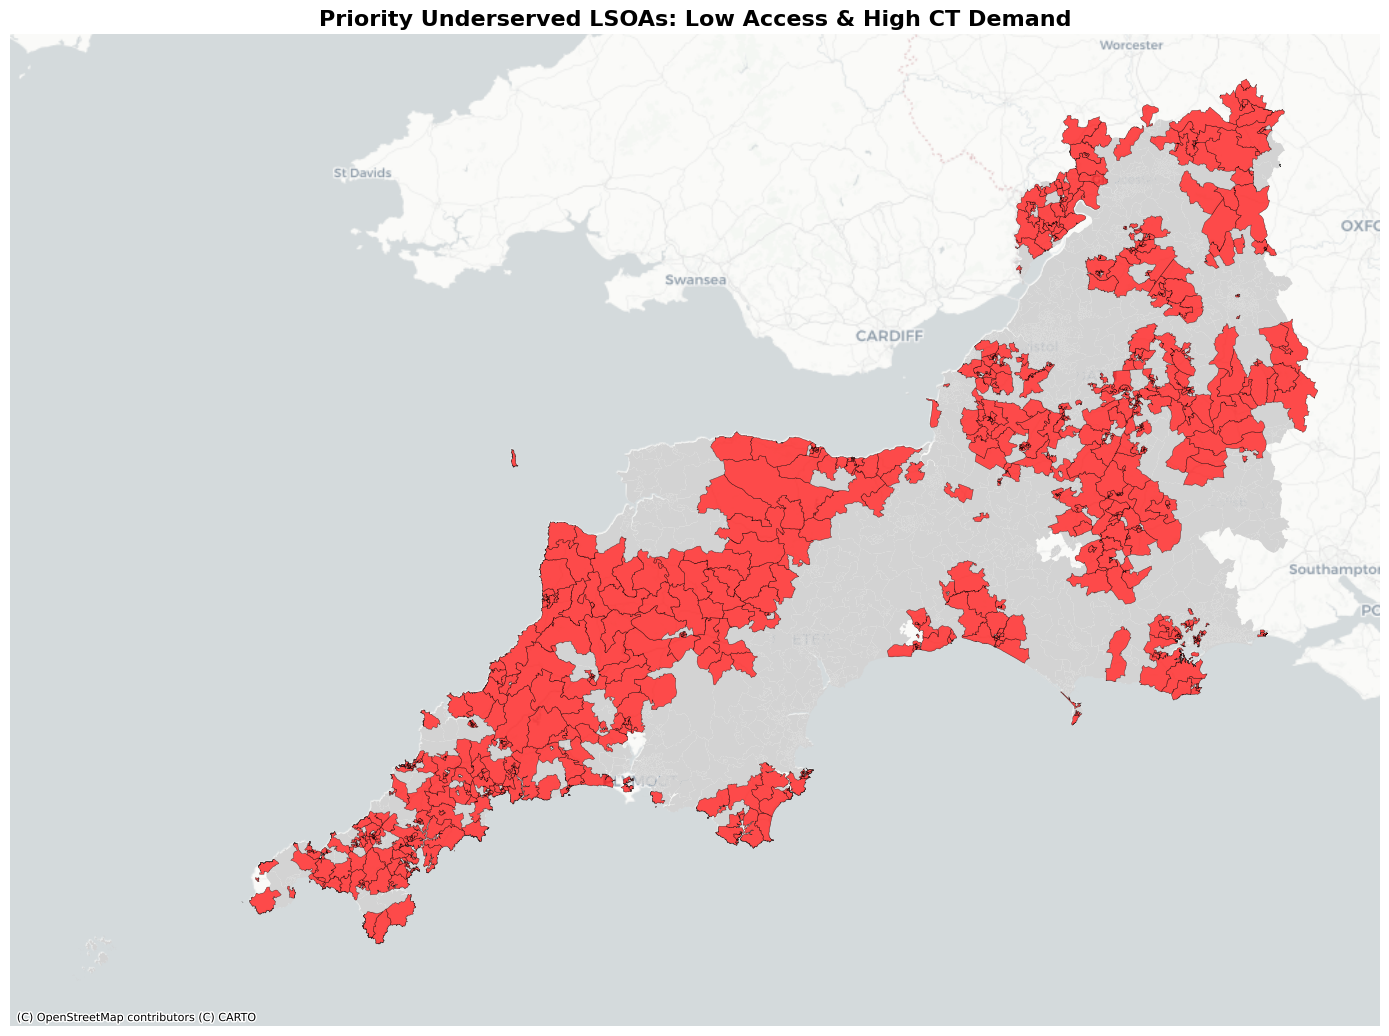

In [8]:
# ----------------------------------------------------------
# Step 2a – Visualise Priority Underserved LSOAs (Preferred Style)
# ----------------------------------------------------------

# Reproject to Web Mercator for tile basemaps
gdf_lsoa_plot = gdf_lsoa.to_crs(epsg=3857)

# Split into priority and non-priority groups
gdf_priority_plot = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == True]
gdf_nonpriority_plot = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == False]

# Plot setup
fig, ax = plt.subplots(figsize=(14, 11))

# Plot non-priority in light grey
gdf_nonpriority_plot.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="none"
)

# Plot priority LSOAs in semi-transparent red with black borders
gdf_priority_plot.plot(
    ax=ax,
    color="red",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.3
)

# Add basemap
ctx.add_basemap(
    ax,
    crs=gdf_lsoa_plot.crs,
    source=ctx.providers.CartoDB.Positron
)

# Formatting
ax.set_title("Priority Underserved LSOAs: Low Access & High CT Demand", fontsize=16, weight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()


In [11]:
# ----------------------------------------------------------
# Step 2b – Propose Total CT Scanner Uplift Scenarios (5%, 10%, 20%)
# ----------------------------------------------------------

# Calculate current total scanners
current_total_scanners = df_sites_ct["CT Scanners"].sum()
print(f"Current total CT scanners: {current_total_scanners}")

# Define percentage increases
uplift_factors = [0.05, 0.10, 0.20]

# Create scenario summary table
uplift_summary = []

for factor in uplift_factors:
    new_total = round(current_total_scanners * (1 + factor))
    uplift = new_total - current_total_scanners
    uplift_summary.append({
        "Scenario": f"+{int(factor * 100)}%",
        "New Total CT Scanners": new_total,
        "Uplift": uplift
    })

# Convert to DataFrame for display
df_uplift = pd.DataFrame(uplift_summary)
print(df_uplift)


Current total CT scanners: 78
  Scenario  New Total CT Scanners  Uplift
0      +5%                     82       4
1     +10%                     86       8
2     +20%                     94      16


In [16]:
# ----------------------------------------------------------
# Step 3 – Cluster and Rank Underserved LSOAs to Propose New Sites
# ----------------------------------------------------------

from sklearn.cluster import KMeans
import geopandas as gpd

def generate_clustered_scenario_sites(gdf_priority, scenario_configs,
                                      score_col="enhanced_3sfca_score",  # <- Updated
                                      demand_col="ct_total_demand"):
    """
    Applies KMeans clustering to identify proposed CT sites under multiple scenarios.

    Parameters:
    - gdf_priority: GeoDataFrame of underserved LSOAs
                    (must include centroid x/y, score, and demand columns)
    - scenario_configs: Dict of form {
          "scenario_name": {
              "n_clusters": int,
              "scanner_allocation": List[int]
          }
      }
    - score_col: Column name of accessibility score (default: 'enhanced_3sfca_score')
    - demand_col: Column name of demand (default: 'ct_total_demand')

    Returns:
    - Dict of {scenario_name: GeoDataFrame of proposed scenario site locations}
    """
    scenario_outputs = {}

    for scenario, config in scenario_configs.items():
        n_clusters = config["n_clusters"]
        scanner_allocation = config["scanner_allocation"]

        if len(scanner_allocation) != n_clusters:
            raise ValueError(
                f"Scenario '{scenario}': scanner_allocation ({len(scanner_allocation)}) "
                f"does not match n_clusters ({n_clusters})"
            )

        # Copy base GeoDataFrame
        gdf_scenario = gdf_priority.copy()

        # Ensure 'x' and 'y' exist
        if "x" not in gdf_scenario.columns or "y" not in gdf_scenario.columns:
            gdf_scenario["centroid"] = gdf_scenario.geometry.centroid
            gdf_scenario["x"] = gdf_scenario["centroid"].x
            gdf_scenario["y"] = gdf_scenario["centroid"].y

        # Apply KMeans
        coords = gdf_scenario[["x", "y"]].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        gdf_scenario["cluster"] = kmeans.fit_predict(coords)

        # Summarise stats per cluster
        cluster_stats = (
            gdf_scenario
            .groupby("cluster")
            .agg(
                total_demand=(demand_col, "sum"),
                avg_access_score=(score_col, "mean"),
                lsoa_count=("lsoa21cd", "count"),
                x_mean=("x", "mean"),
                y_mean=("y", "mean")
            )
            .reset_index()
        )

        # Composite ranking: high demand, low access
        cluster_stats["rank_score"] = (
            cluster_stats["total_demand"].rank(ascending=False) +
            cluster_stats["avg_access_score"].rank(ascending=True)
        )
        cluster_stats["rank"] = cluster_stats["rank_score"].rank(method="dense").astype(int)

        # Assign scanners and name sites
        cluster_stats = cluster_stats.sort_values("rank").reset_index(drop=True)
        cluster_stats["CT Scanners"] = scanner_allocation[:len(cluster_stats)]
        cluster_stats["Site Name"] = cluster_stats.index.map(lambda i: f"Scenario Site {i+1}")
        cluster_stats["Type"] = f"Scenario {scenario}"

        # Convert to GeoDataFrame
        gdf_sites = gpd.GeoDataFrame(
            cluster_stats,
            geometry=gpd.points_from_xy(cluster_stats["x_mean"], cluster_stats["y_mean"]),
            crs=gdf_priority.crs
        )

        scenario_outputs[scenario] = gdf_sites

    return scenario_outputs


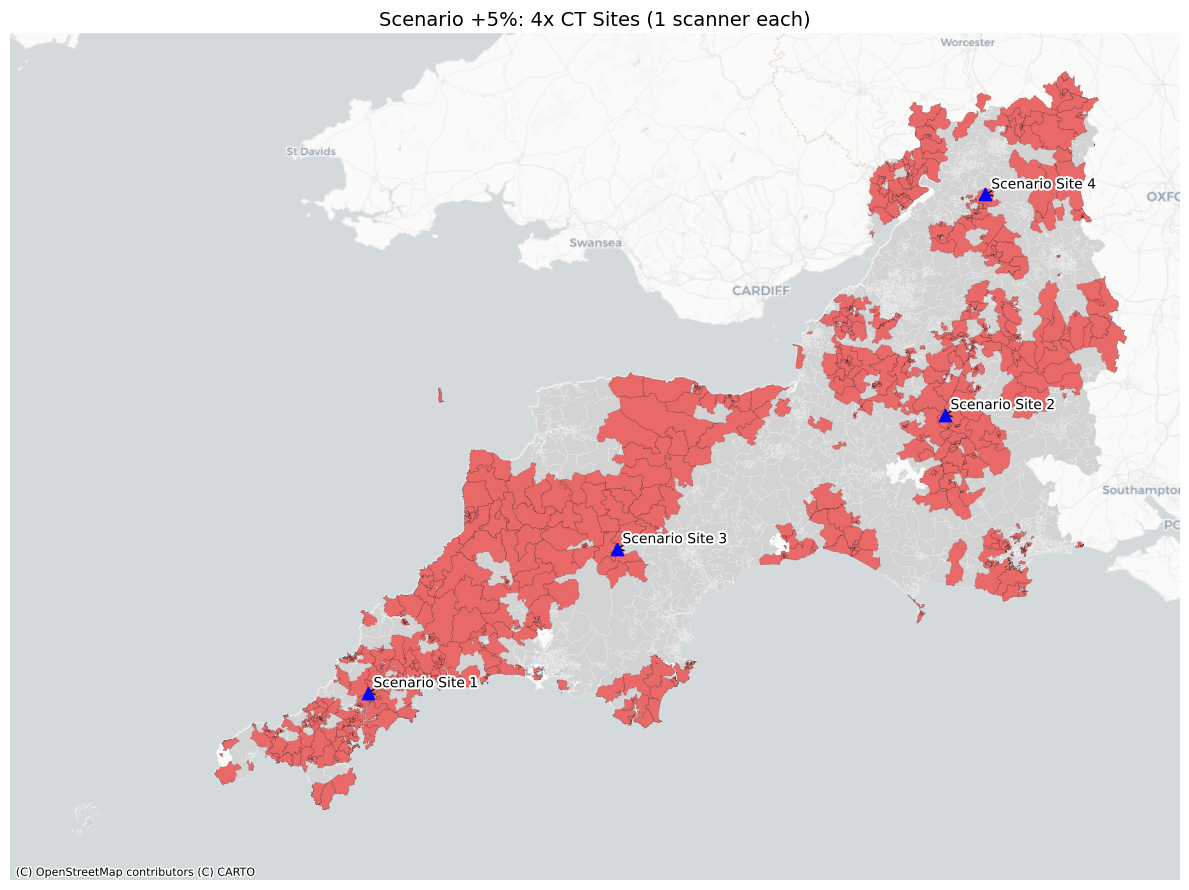

In [18]:
# ----------------------------------------------------------
# Step 3a – +5% Scenario: 4x CT Sites (1 scanner each)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Ensure centroid, x, y columns exist
if "x" not in gdf_priority.columns or "y" not in gdf_priority.columns:
    gdf_priority["centroid"] = gdf_priority.geometry.centroid
    gdf_priority["x"] = gdf_priority["centroid"].x
    gdf_priority["y"] = gdf_priority["centroid"].y

# Define scenario configuration
config_5 = {"+5%": {"n_clusters": 4, "scanner_allocation": [1, 1, 1, 1]}}

# Generate proposed site locations
sites_5pct = generate_clustered_scenario_sites(gdf_priority, config_5)["+5%"]
sites_5pct = sites_5pct.to_crs(epsg=3857)

# Reproject base and priority LSOAs
gdf_base = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_plot = gdf_priority.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_base.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1)
gdf_priority_plot.plot(ax=ax, color="red", alpha=0.5, edgecolor="black", linewidth=0.2)

# Plot scenario sites (1 scanner each only)
for _, row in sites_5pct.iterrows():
    ax.scatter(row.geometry.x, row.geometry.y, marker="^", s=80, color="blue", zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(row.geometry.x + 3000, row.geometry.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Basemap and title
ctx.add_basemap(ax, crs=sites_5pct.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Scenario +5%: 4x CT Sites (1 scanner each)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


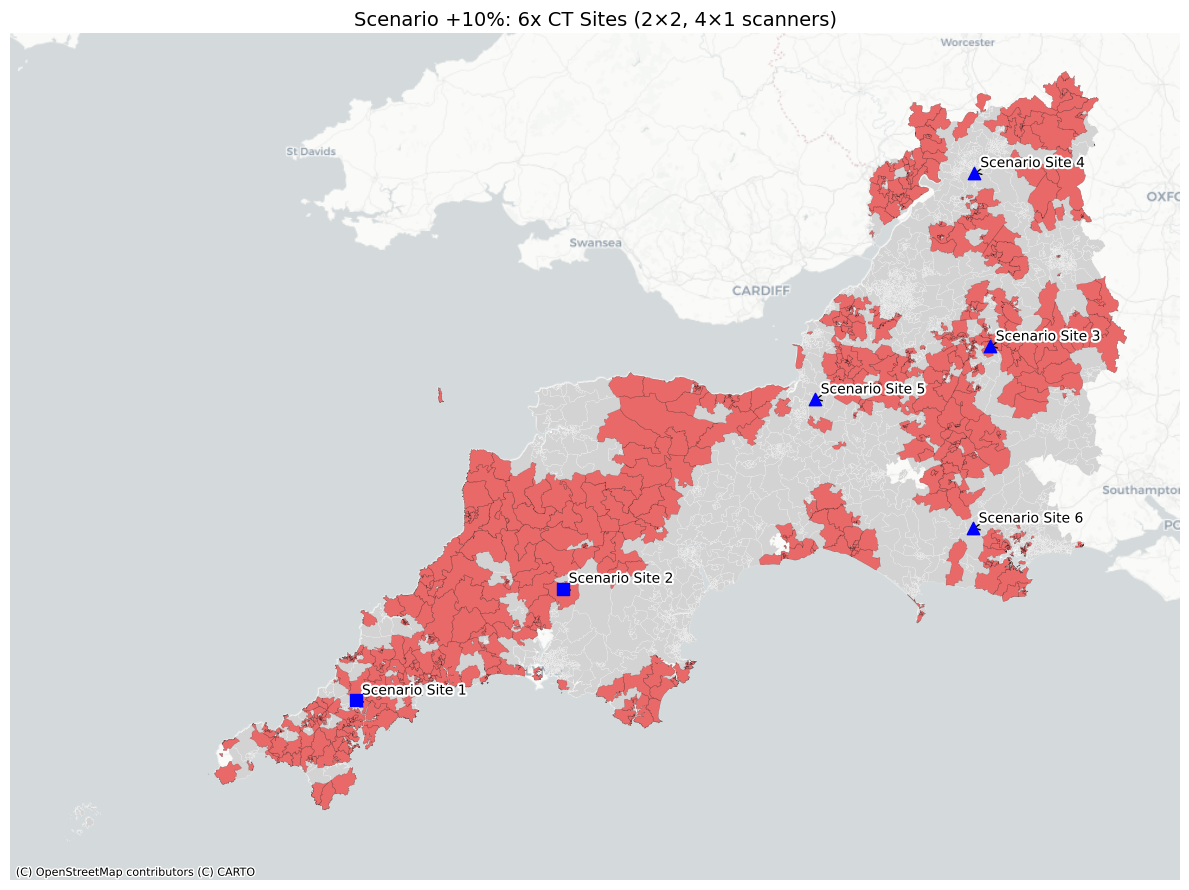

In [19]:
# ----------------------------------------------------------
# Step 3b – +10% Scenario: 6x CT Sites (2, 2, 1, 1, 1, 1)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Define scenario config
config_10 = {"+10%": {"n_clusters": 6, "scanner_allocation": [2, 2, 1, 1, 1, 1]}}

# Generate clustered site locations
sites_10pct = generate_clustered_scenario_sites(gdf_priority, config_10)["+10%"]
sites_10pct = sites_10pct.to_crs(epsg=3857)

# Reproject LSOAs
gdf_base = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_plot = gdf_priority.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_base.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1)
gdf_priority_plot.plot(ax=ax, color="red", alpha=0.5, edgecolor="black", linewidth=0.2)

# Plot sites with different markers for 1 vs 2 scanners
for _, row in sites_10pct.iterrows():
    marker = "^" if row["CT Scanners"] == 1 else "s"
    ax.scatter(row.geometry.x, row.geometry.y, marker=marker, s=80, color="blue", zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(row.geometry.x + 3000, row.geometry.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

ctx.add_basemap(ax, crs=sites_10pct.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Scenario +10%: 6x CT Sites (2×2, 4×1 scanners)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


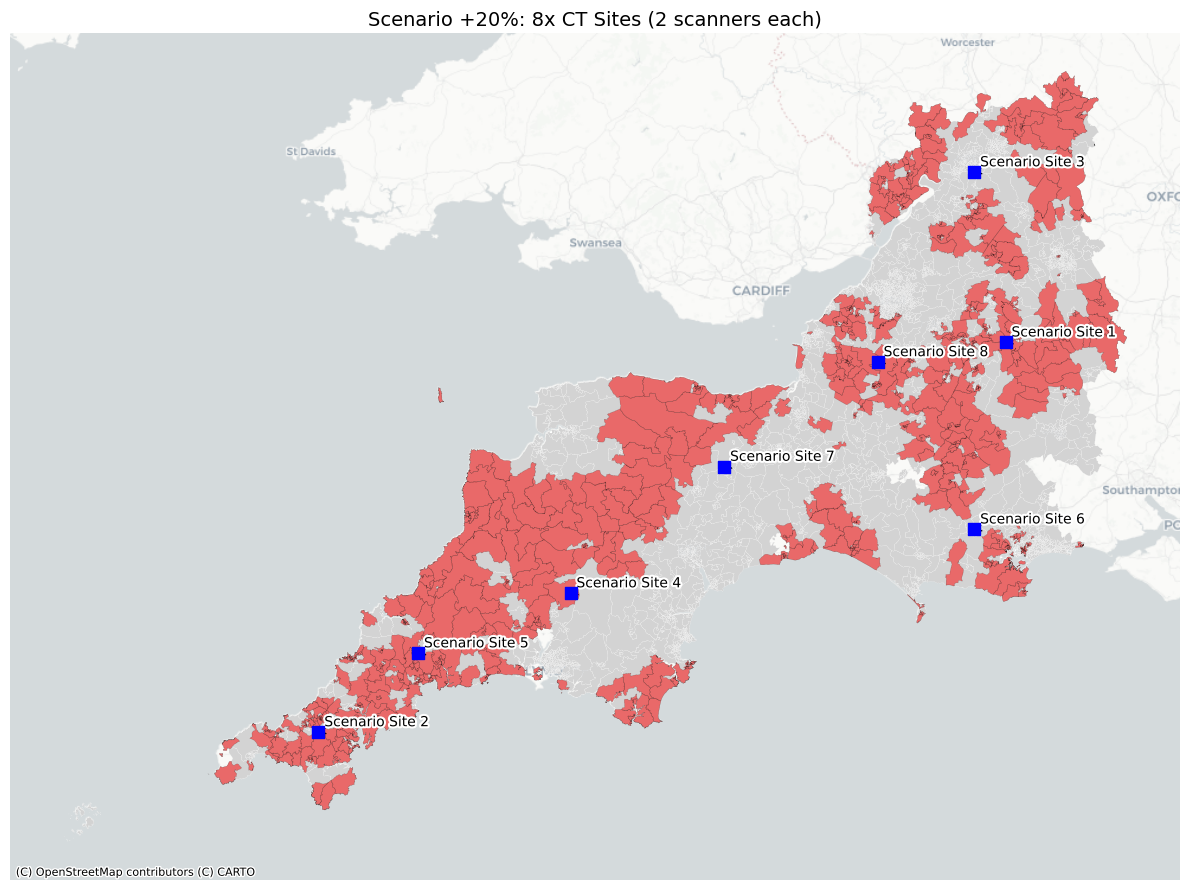

In [20]:
# ----------------------------------------------------------
# Step 3c – +20% Scenario: 8x CT Sites (2 scanners each)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Define scenario config
config_20 = {"+20%": {"n_clusters": 8, "scanner_allocation": [2] * 8}}

# Generate clustered site locations
sites_20pct = generate_clustered_scenario_sites(gdf_priority, config_20)["+20%"]
sites_20pct = sites_20pct.to_crs(epsg=3857)

# Reproject LSOAs
gdf_base = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_plot = gdf_priority.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_base.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1)
gdf_priority_plot.plot(ax=ax, color="red", alpha=0.5, edgecolor="black", linewidth=0.2)

# Plot all sites as squares (2 scanners)
for _, row in sites_20pct.iterrows():
    ax.scatter(row.geometry.x, row.geometry.y, marker="s", s=80, color="blue", zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(row.geometry.x + 3000, row.geometry.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

ctx.add_basemap(ax, crs=sites_20pct.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Scenario +20%: 8x CT Sites (2 scanners each)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [22]:
# ----------------------------------------------------------
# Step 4 – Print Ranked Summary of Proposed Sites per Scenario
# ----------------------------------------------------------

columns_to_show = ["Site Name", "total_demand", "avg_access_score", "rank"]

# +5% Scenario
print("\n+5% Scenario: 4x CT Sites (1 scanner each)")
print(sites_5pct[columns_to_show].sort_values("rank").to_string(index=False))

# +10% Scenario
print("\n+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)")
print(sites_10pct[columns_to_show].sort_values("rank").to_string(index=False))

# +20% Scenario
print("\n+20% Scenario: 8x CT Sites (2 scanners each)")
print(sites_20pct[columns_to_show].sort_values("rank").to_string(index=False))



+5% Scenario: 4x CT Sites (1 scanner each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 1  40351.897797          0.030757     1
Scenario Site 2  67896.413155          0.051704     2
Scenario Site 3  33007.721739          0.037511     2
Scenario Site 4  32844.513992          0.048879     3

+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 1  35972.891493          0.029831     1
Scenario Site 2  28912.210980          0.038552     2
Scenario Site 3  33345.247561          0.046634     2
Scenario Site 4  26949.196281          0.047287     3
Scenario Site 5  26368.588763          0.051021     4
Scenario Site 6  22552.411604          0.055966     5

+20% Scenario: 8x CT Sites (2 scanners each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 1  27309.708174          0.045502     1
Scenario Site 2  20604.175444          0.030341     2
Scenario Site 3  26680.864007          0.047099     

In [34]:
# ----------------------------------------------------------
# Step 5 – Match Scenario Sites to Nearest LSOAs by Coordinate
# ----------------------------------------------------------

import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load LSOA Segment Master
lsoa_segment_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw/LSOA_5-year_segment_master.gpkg"
gdf_segment = gpd.read_file(lsoa_segment_path)

# Prepare coordinates in BNG (EPSG:27700)
lsoa_coords = gdf_segment[["lsoa21cd", "bng_e", "bng_n"]].dropna().copy()

# Apply projection and extract BNG coordinates
sites_5pct = sites_5pct.to_crs(epsg=27700)
sites_10pct = sites_10pct.to_crs(epsg=27700)
sites_20pct = sites_20pct.to_crs(epsg=27700)

for df in [sites_5pct, sites_10pct, sites_20pct]:
    df["bng_e"] = df.geometry.x
    df["bng_n"] = df.geometry.y

# Fit Nearest Neighbours model
nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree")
nn.fit(lsoa_coords[["bng_e", "bng_n"]])

# Match each scenario
for df in [sites_5pct, sites_10pct, sites_20pct]:
    distances, indices = nn.kneighbors(df[["bng_e", "bng_n"]])
    df["nearest_lsoa21cd"] = lsoa_coords.iloc[indices.flatten()]["lsoa21cd"].values
    df["distance_m"] = distances.flatten()

# ----------------------------------------------------------
# Step 6 – Print Ranked Summary of Proposed Sites per Scenario
# ----------------------------------------------------------

columns_to_show = ["Site Name", "total_demand", "avg_access_score", "rank", "nearest_lsoa21cd", "distance_m"]

# +5% Scenario
print("\n+5% Scenario: 4x CT Sites (1 scanner each)")
print(sites_5pct[columns_to_show].sort_values("rank").to_string(index=False))

# +10% Scenario
print("\n+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)")
print(sites_10pct[columns_to_show].sort_values("rank").to_string(index=False))

# +20% Scenario
print("\n+20% Scenario: 8x CT Sites (2 scanners each)")
print(sites_20pct[columns_to_show].sort_values("rank").to_string(index=False))



+5% Scenario: 4x CT Sites (1 scanner each)
      Site Name  total_demand  avg_access_score  rank nearest_lsoa21cd  distance_m
Scenario Site 1  40351.897797          0.030757     1        E01018815 3637.025974
Scenario Site 2  67896.413155          0.051704     2        E01032036 2521.434037
Scenario Site 3  33007.721739          0.037511     2        E01020319 1126.529078
Scenario Site 4  32844.513992          0.048879     3        E01022354 1126.114214

+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)
      Site Name  total_demand  avg_access_score  rank nearest_lsoa21cd  distance_m
Scenario Site 1  35972.891493          0.029831     1        E01018857 1363.017164
Scenario Site 2  28912.210980          0.038552     2        E01020324 2023.718439
Scenario Site 3  33345.247561          0.046634     2        E01034540 1449.798755
Scenario Site 4  26949.196281          0.047287     3        E01022276 1569.318789
Scenario Site 5  26368.588763          0.051021     4        E01029152  538.51

In [44]:
# ----------------------------------------------------------
# Step 7 – Prepare GeoDataFrames for Facility Visualisation
# ----------------------------------------------------------
import geopandas as gpd
from shapely.geometry import Point

# Convert Acute and CDC to GeoDataFrames (EPSG:4326)
acute_gdf = gpd.GeoDataFrame(
    df_acute_ct.copy(),
    geometry=gpd.points_from_xy(df_acute_ct["longitude"], df_acute_ct["latitude"]),
    crs="EPSG:4326"
)
acute_gdf["site_type"] = "Acute Hospital"
acute_gdf["scanner_count"] = acute_gdf["CT Scanners"]

cdc_gdf = gpd.GeoDataFrame(
    df_cdc_ct.copy(),
    geometry=gpd.points_from_xy(df_cdc_ct["longitude"], df_cdc_ct["latitude"]),
    crs="EPSG:4326"
)
cdc_gdf["site_type"] = "CDC"
cdc_gdf["scanner_count"] = cdc_gdf["CT Scanners"]

# ----------------------------------------------------------
# Step 7b – Convert +10% Scenario Sites to GeoDataFrame
# ----------------------------------------------------------

# Assume `sites_10pct` includes 'Site Name', 'nearest_lsoa21cd', 'rank', etc.

# Merge with segment master to get lat/lon for each LSOA centroid
scenario_gdf_10pct = sites_10pct.merge(
    gdf_segment[["lsoa21cd", "lat", "long"]],
    left_on="nearest_lsoa21cd",
    right_on="lsoa21cd",
    how="left"
)

# Assign scanner count: 2 sites with 2, 4 sites with 1
scanner_counts = [2, 2, 1, 1, 1, 1]
scenario_gdf_10pct["scanner_count"] = scanner_counts
scenario_gdf_10pct["site_type"] = "Scenario Site"

# Create geometry column
scenario_gdf_10pct = gpd.GeoDataFrame(
    scenario_gdf_10pct.copy(),
    geometry=gpd.points_from_xy(scenario_gdf_10pct["long"], scenario_gdf_10pct["lat"]),
    crs="EPSG:4326"
)
